In [1]:
import os
import numpy as np
import xarray as xr
import numpy.testing as npt
import matplotlib.pyplot as plt

In [2]:
from gridmet_bmi import BmiGridmet
os.getcwd()

'/home/rmcd/git/gridmet_bmi/notebooks'

In [3]:
x = BmiGridmet()
x.initialize('../examples/gridmet_bmi.yaml')

../examples/gridmet_bmi.yaml
...



In [4]:
print(x.get_component_name())

Gridmet_BMI


In [5]:
print(x.get_input_var_names())
print(x.get_output_var_names())



('daily_maximum_temperature', 'daily_minimum_temperature', 'precipitation_amount')


In [6]:
grid_id = x.get_var_grid('daily_maximum_temperature')
size = x.get_grid_size(grid_id)
bmivals = np.empty(size)
shape = np.empty(2, dtype=np.int)
x.get_grid_shape(grid_id, shape)
x.get_value('daily_maximum_temperature', bmivals)
origin = np.empty(2, dtype=np.float)
delta = np.empty(2, dtype=np.float)
x.get_grid_origin(grid_id, origin)
x.get_grid_spacing(grid_id, delta)
print(origin, delta)
x.get_current_time()

[  25.06666667 -124.76666663] [0.04166667 0.04166667]


0.0

In [7]:
hruid = 'nhru_v11' # for GFv11_v2e
uofi_file = '../examples/agg_met_tmmx_20200101_20200107.nc'
ds = xr.open_dataset(uofi_file)
print(ds, flush=True)
#Read NHM hru shapefiles into geopandas dataframe
print(os.getcwd(), flush=True)

<xarray.Dataset>
Dimensions:                    (day: 7, lat: 585, lon: 1386)
Coordinates:
  * day                        (day) datetime64[ns] 2020-01-01 ... 2020-01-07
  * lat                        (lat) float64 49.4 49.36 49.32 ... 25.11 25.07
  * lon                        (lon) float64 -124.8 -124.7 ... -67.1 -67.06
Data variables:
    daily_maximum_temperature  (day, lat, lon) float32 ...
Attributes:
    geospatial_bounds_crs:      EPSG:4326
    Conventions:                CF-1.0
    geospatial_bounds:          POLYGON((-124.7666666333333 49.40000000000000...
    geospatial_lat_min:         25.066666666666666
    geospatial_lat_max:         49.400000000000006
    geospatial_lon_min:         -124.76666663333334
    geospatial_lon_max:         -67.05833330000002
    geospatial_lon_resolution:  0.041666666666666
    geospatial_lat_resolution:  0.041666666666666
    geospatial_lat_units:       decimal_degrees north
    geospatial_lon_units:       decimal_degrees east
    coordinate_s

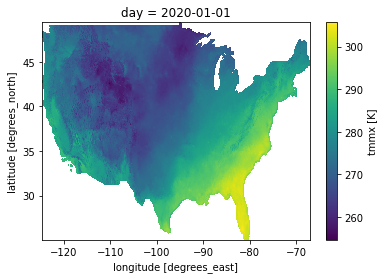

In [8]:
temp = ds.daily_maximum_temperature
temp1 = temp.isel(day=0)
temp1.plot()

In [9]:
rawvals = temp1.values

In [10]:
print(f'rawvalues shape {rawvals.shape}')
print(f'bmivalues shape {bmivals.shape}')
bmivals_reshape = np.reshape(bmivals, shape)
print(f'bmivalues reshape {bmivals_reshape.shape}')

rawvalues shape (585, 1386)
bmivalues shape (810810,)
bmivalues reshape (585, 1386)


In [11]:
npt.assert_equal(np.flipud(rawvals), bmivals_reshape)

In [12]:
lon, lat = np.meshgrid(ds['lon'], ds['lat'])

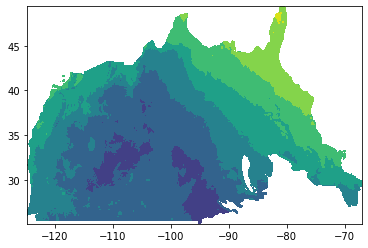

In [13]:
plt.contourf(ds['lon'],ds['lat'], bmivals_reshape)

In [14]:
 
newlat = np.empty(bmivals_reshape.shape[0], dtype=np.float)
newlon = np.empty(bmivals_reshape.shape[1], dtype=np.float)
   

In [15]:
print(delta, origin)

for index, val in np.ndenumerate(newlat):
    newlat[index[0]] = origin[0] + (index[0]*delta[0])
    
for index, val in np.ndenumerate(newlon):
    newlon[index[0]] = origin[1] + (index[0]*delta[1])
    
print(newlat.shape, newlon.shape)
print(np.min(newlat), np.max(newlat))
print(np.min(newlon), np.max(newlon))

[0.04166667 0.04166667] [  25.06666667 -124.76666663]
(585,) (1386,)
25.066666666666666 49.39999999999961
-124.76666663333334 -67.05833330000094


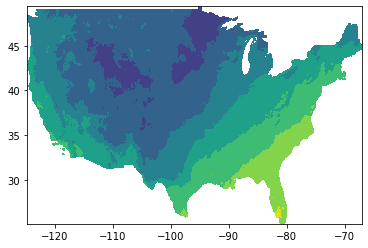

In [17]:
plt.contourf(newlon, newlat, bmivals_reshape)

In [22]:
import rasterstats as rstats
import rasterio as rio
#collect data to describe geotransform
lonmin = float(ds.attrs['geospatial_lon_min'])
latmax = float(ds.attrs['geospatial_lat_max'])
lonres = float(ds.attrs['geospatial_lon_resolution'])
latres = float(ds.attrs['geospatial_lon_resolution'])

transform = rio.transform.from_origin( lonmin, latmax, lonres, latres)
print(transform)

| 0.04, 0.00,-124.77|
| 0.00,-0.04, 49.40|
| 0.00, 0.00, 1.00|


In [32]:
print(bmivals_reshape.dtype)
print(len(newlat), len(newlon))

float64
585 1386


### Create Geotiff from temperature array

In [34]:
geodata = rio.open('test.tif', 'w', driver='GTiff',
                  height=len(newlat), width=len(newlon),
                  count=1, dtype=bmivals_reshape.dtype,
                  crs={'init': 'epsg:4326'},
                  transform=transform)
geodata.write(np.flipud(bmivals_reshape)-273.15, 1)
geodata.close()


### Test rasterstats

In [38]:
import geopandas as gpd
import pandas as pd
# read hru shapefile
hrudata = gpd.GeoDataFrame.from_file('./GIS/nhru_10U.shp')

In [42]:
stats = rstats.zonal_stats(hrudata, np.flipud(bmivals_reshape)-273.15,
                          transform=transform.to_gdal(),
                          prefix='tmax_')
statsdf = pd.DataFrame(stats)
zonalhru = hrudata.join(statsdf)


/home/rmcd/miniconda3/envs/gridmet_bmi/lib/python3.8/site-packages/rasterstats/io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


<AxesSubplot:>

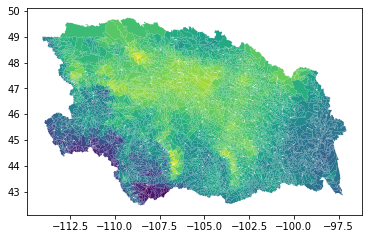

In [43]:
zonalhru.plot(column='tmax_mean')

In [47]:
import gridmetetl
fp = gridmetetl.FpoNHM()

In [59]:
import datetime
startd = datetime.date(year=2020, month=1, day=1)
endd = datetime.date(year=2020, month=1, day=2)
fp.initialize(False, '', './GIS/.', 
             '.', './GIS/weights.csv', etype='date', days=0,
             fileprefix='gm_', start_date=startd,
             end_date=endd)

input path exists GIS
output path exists
weights file exists GIS/weights.csv
/home/rmcd/git/gridmet_bmi/notebooks
start_date: 2020-01-01 and end_date: 2020-01-02
the shapefile filenames read: [PosixPath('GIS/nhru_10U.shp'), PosixPath('GIS/nsegment_10U.shp')]
the shapefile header is:        POI_ID                                           geometry  hru_id_nat  \
0  16101051.0  POLYGON ((-103.83184 42.66720, -103.83147 42.6...     55584.0   
1  16101337.0  POLYGON ((-103.39134 42.56509, -103.39171 42.5...     55585.0   
2  16101347.0  POLYGON ((-103.74343 42.63506, -103.74364 42.6...     55586.0   
3  16101051.0  POLYGON ((-103.75814 42.68535, -103.75778 42.6...     55587.0   
4  16101347.0  POLYGON ((-103.76344 42.68315, -103.76341 42.6...     55588.0   

   hru_id_reg region  seg_id_nat  seg_id_reg  tosegment  
0         1.0    10U         NaN         NaN        NaN  
1         2.0    10U         NaN         NaN        NaN  
2         3.0    10U         NaN         NaN        NaN  
3  

True

In [60]:
fp.run_weights()

finished reading weight file
Processing day: 0
Processing day: 1


In [61]:
fp.finalize()

/home/rmcd/git/gridmet_bmi/notebooks


/home/rmcd/git/gridmetetl/gridmetetl/etl.py:431: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroidseries = self.gdf1.geometry.centroid


('hruid', <class 'netCDF4._netCDF4.Dimension'>: name = 'hruid', size = 10299)
('time', <class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'time', size = 0)
dataset is closed


In [64]:
gmdata = xr.open_dataset('gm_climate_2020_09_01.nc')

In [65]:
gmtmax = gmdata.tmax.sel(time='2020-01-01')

In [67]:
zonalhru['gmtmax'] = gmtmax.values

<AxesSubplot:>

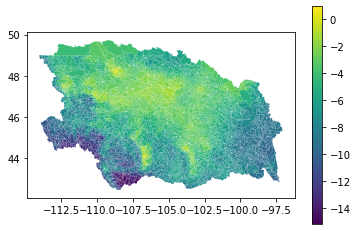

In [72]:
zonalhru.plot(column='tmax_mean',legend=True)

<AxesSubplot:>

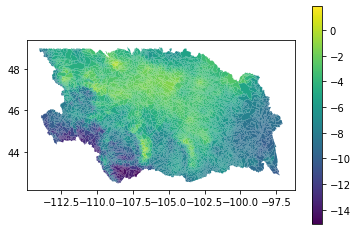

In [73]:
zonalhru.plot(column='gmtmax',legend=True)

In [75]:
zonalhru['diff'] = zonalhru.apply(lambda row: row['tmax_mean'] - row['gmtmax'], axis=1)

<AxesSubplot:>

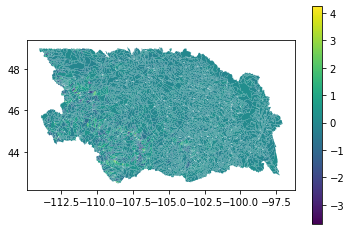

In [76]:
zonalhru.plot(column='diff',legend=True)